<a href="https://colab.research.google.com/github/vkth7/AIFFEL-exploration/blob/main/exp-08/%5Bexp-08%5D%20%EC%98%81%ED%99%94%20%EB%A6%AC%EB%B7%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-08-19 06:03:57--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-08-19 06:03:57--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0dd1e669edbc4fe22cf2f1380c.dl.dropboxusercontent.com/cd/0/get/BrQiZDz0OS19aPKRLeM1syFG--AyG4SoBJ8qIpln1aZsLQ9XC1xNEEbst6ONkZIDrK2YaAreJcPjjm6US9YD-yiFE7Vs-Gue4ESxyqG3_IHyQKc5isjQPUQ13h4dkKbTUnrCseGXvk3TfzUjEpD4UAvKNKfSQppZSVaYQzbhZqvYyQ2zUppXFKNjbZTVP_wIsRU/file?dl=1# [following]
--2022-08-19 06:03:58--  https://uc0dd1e669edbc4fe22cf2f1380c.dl.dropboxusercontent.com/cd/0/get/

In [ ]:
import pandas as pd
import konlpy
import gensim
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
from tensorflow import keras

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.5
0.6.0
3.6.0


# 1) 데이터 준비와 확인

In [ ]:
# 데이터 읽어오기
train_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/exp-08/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/exp-08/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [ ]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 중복행 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    # 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any') 
    
    # X_train tokenizer
    X_train = []
    for sentence in train_data['document']:
        # tokenizer
        temp_X = tokenizer.morphs(sentence)
        # stopwords 제거
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_train.append(temp_X)

    # X_test tokenizer
    X_test = []
    for sentence in test_data['document']:
        # tokenizer
        temp_X = tokenizer.morphs(sentence) 
        # stopwords 제거
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>',''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
len(word_to_index)

10001

In [ ]:
len(X_train)

146182

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [ ]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [ ]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                     value=word_to_index['<PAD>'],
                                                     padding='post',
                                                     maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                    value=word_to_index['<PAD>'],
                                                    padding='post',
                                                    maxlen=maxlen)

# 4) 모델 구성 및 validation set 구성

In [ ]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기(10001개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수

# LSTM
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(512))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 4)           40004     
                                                                 
 lstm (LSTM)                 (None, 512)               1058816   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,230,405
Trainable params: 1,230,405
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 1-D CNN
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 4)           40004     
                                                                 
 conv1d (Conv1D)             (None, None, 16)          464       
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

In [ ]:
# Global MaxPooling1D 만 사용
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 4)           40004     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 4)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 40        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 40,053
Trainable params: 40,053
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# validation dataset
x_val = x_train[:60000]
y_val = y_train[:60000]
x = x_train[60000:]
y = y_train[60000:]
print(x_val.shape, x.shape, x_train.shape)

(60000, 41) (86182, 41) (146182, 41)


# 5) 모델 훈련 개시

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(x,
                    y,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

Epoch 1/10
1347/1347 [==============================] - 20s 13ms/step - loss: 0.5355 - accuracy: 0.6920 - val_loss: 0.3775 - val_accuracy: 0.8328
Epoch 2/10
1347/1347 [==============================] - 17s 12ms/step - loss: 0.3544 - accuracy: 0.8505 - val_loss: 0.3672 - val_accuracy: 0.8424
Epoch 3/10
1347/1347 [==============================] - 17s 12ms/step - loss: 0.3222 - accuracy: 0.8646 - val_loss: 0.3635 - val_accuracy: 0.8389
Epoch 4/10
1347/1347 [==============================] - 17s 12ms/step - loss: 0.2978 - accuracy: 0.8753 - val_loss: 0.3627 - val_accuracy: 0.8505
Epoch 5/10
1347/1347 [==============================] - 17s 12ms/step - loss: 0.2785 - accuracy: 0.8844 - val_loss: 0.3694 - val_accuracy: 0.8499
Epoch 6/10
1347/1347 [==============================] - 17s 12ms/step - loss: 0.2620 - accuracy: 0.8920 - val_loss: 0.3589 - val_accuracy: 0.8511
Epoch 7/10
1347/1347 [==============================] - 17s 12ms/step - loss: 0.2457 - accuracy: 0.8981 - val_loss: 0.3615 -

In [ ]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history2 = model2.fit(x,
                      y,
                      epochs=epochs,
                      batch_size=512,
                      validation_data=(x_val, y_val),
                      verbose=1)
results2 = model2.evaluate(x_test,  y_test, verbose=2)

print(results)

Epoch 1/10
169/169 [==============================] - 2s 7ms/step - loss: 0.5881 - accuracy: 0.6856 - val_loss: 0.4093 - val_accuracy: 0.8213
Epoch 2/10
169/169 [==============================] - 1s 5ms/step - loss: 0.3714 - accuracy: 0.8408 - val_loss: 0.3694 - val_accuracy: 0.8405
Epoch 3/10
169/169 [==============================] - 1s 5ms/step - loss: 0.3330 - accuracy: 0.8607 - val_loss: 0.3623 - val_accuracy: 0.8429
Epoch 4/10
169/169 [==============================] - 1s 5ms/step - loss: 0.3140 - accuracy: 0.8701 - val_loss: 0.3650 - val_accuracy: 0.8421
Epoch 5/10
169/169 [==============================] - 1s 5ms/step - loss: 0.3015 - accuracy: 0.8762 - val_loss: 0.3655 - val_accuracy: 0.8422
Epoch 6/10
169/169 [==============================] - 1s 5ms/step - loss: 0.2921 - accuracy: 0.8809 - val_loss: 0.3723 - val_accuracy: 0.8410
Epoch 7/10
169/169 [==============================] - 1s 5ms/step - loss: 0.2830 - accuracy: 0.8852 - val_loss: 0.3736 - val_accuracy: 0.8418
Epoch 

In [ ]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history3 = model3.fit(x,
                      y,
                      epochs=epochs,
                      batch_size=512,
                      validation_data=(x_val, y_val),
                      verbose=1)
results3 = model3.evaluate(x_test,  y_test, verbose=2)

print(results)

Epoch 1/10
169/169 [==============================] - 1s 5ms/step - loss: 0.6799 - accuracy: 0.6338 - val_loss: 0.6483 - val_accuracy: 0.7458
Epoch 2/10
169/169 [==============================] - 1s 4ms/step - loss: 0.5679 - accuracy: 0.7807 - val_loss: 0.4820 - val_accuracy: 0.7965
Epoch 3/10
169/169 [==============================] - 1s 4ms/step - loss: 0.4285 - accuracy: 0.8187 - val_loss: 0.4123 - val_accuracy: 0.8156
Epoch 4/10
169/169 [==============================] - 1s 4ms/step - loss: 0.3775 - accuracy: 0.8386 - val_loss: 0.3944 - val_accuracy: 0.8221
Epoch 5/10
169/169 [==============================] - 1s 4ms/step - loss: 0.3522 - accuracy: 0.8505 - val_loss: 0.3884 - val_accuracy: 0.8248
Epoch 6/10
169/169 [==============================] - 1s 4ms/step - loss: 0.3352 - accuracy: 0.8585 - val_loss: 0.3864 - val_accuracy: 0.8265
Epoch 7/10
169/169 [==============================] - 1s 4ms/step - loss: 0.3220 - accuracy: 0.8647 - val_loss: 0.3868 - val_accuracy: 0.8279
Epoch 

# 6) Loss, Accuracy 그래프 시각화

In [ ]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3983 - accuracy: 0.8432 - 5s/epoch - 3ms/step
[0.39826831221580505, 0.8432369828224182]


In [ ]:
results2 = model2.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3987 - accuracy: 0.8357 - 3s/epoch - 2ms/step
[0.39826831221580505, 0.8432369828224182]


In [ ]:
results3 = model3.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4027 - accuracy: 0.8259 - 2s/epoch - 1ms/step
[0.39826831221580505, 0.8432369828224182]


In [ ]:
history_dict = history.history
# epoch에 따른 그래프를 그려볼 수 있는 항목들
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
history_dict2 = history2.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
history_dict3 = history3.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


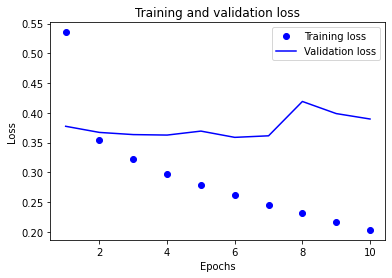

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

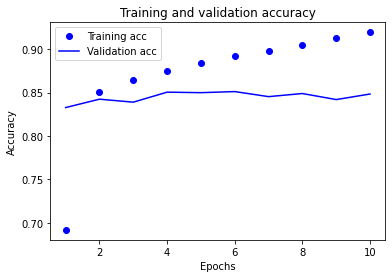

In [ ]:
plt.clf()   # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

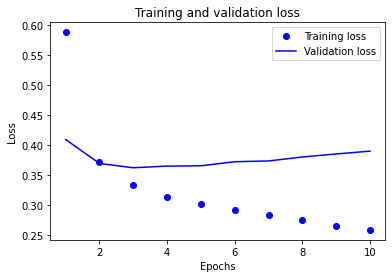

In [ ]:
acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

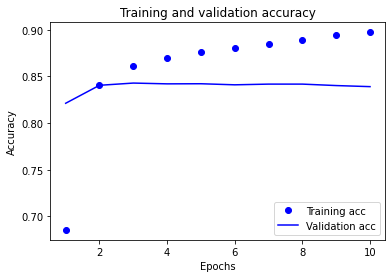

In [ ]:
plt.clf()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

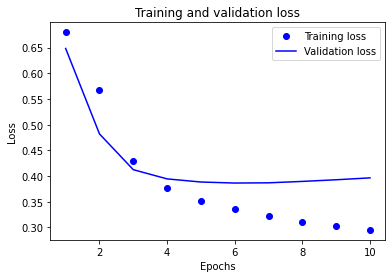

In [ ]:
acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

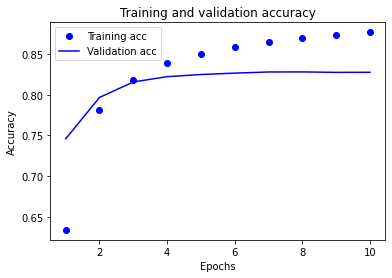

In [ ]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7) 학습된 Embedding 레이어 분석

In [ ]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10001, 4)


In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = '/content/drive/MyDrive/Colab Notebooks/exp-08/word2vec.txt'
f = open(word2vec_file_path, 'w')
# 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

# 단어 개수 만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([-0.12214261, -0.18077363,  0.15582868, -0.24859925], dtype=float32)

In [ ]:
word_vectors.similar_by_word("사랑")

[('전해', 0.9998260140419006),
 ('강지환', 0.9997936487197876),
 ('빛나', 0.998428463935852),
 ('비극', 0.9981133341789246),
 ('평화', 0.9981024861335754),
 ('에게서', 0.9974337816238403),
 ('그놈', 0.9973143935203552),
 ('간지', 0.9968979358673096),
 ('키운', 0.9968411326408386),
 ('뛰어넘', 0.9964039325714111)]

# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = '/content/drive/MyDrive/Colab Notebooks/exp-08/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['사랑']
vector.shape

(100,)

In [ ]:
word_vectors.similar_by_word("사랑")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('이별', 0.7626415491104126),
 ('행복', 0.7550067901611328),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588401794434),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [ ]:
word_vector_dim = 100 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 저장
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [ ]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 41, 100)           1000100   
                                                                 
 conv1d_2 (Conv1D)           (None, 35, 16)            11216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 16)            0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 16)             1808      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 8)                

In [ ]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(x,
                    y,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
169/169 [==============================] - 2s 8ms/step - loss: 0.6387 - accuracy: 0.6199 - val_loss: 0.5404 - val_accuracy: 0.7323
Epoch 2/10
169/169 [==============================] - 1s 6ms/step - loss: 0.4906 - accuracy: 0.7669 - val_loss: 0.4631 - val_accuracy: 0.7853
Epoch 3/10
169/169 [==============================] - 1s 6ms/step - loss: 0.4208 - accuracy: 0.8097 - val_loss: 0.4191 - val_accuracy: 0.8110
Epoch 4/10
169/169 [==============================] - 1s 7ms/step - loss: 0.3779 - accuracy: 0.8335 - val_loss: 0.4257 - val_accuracy: 0.8053
Epoch 5/10
169/169 [==============================] - 1s 6ms/step - loss: 0.3485 - accuracy: 0.8503 - val_loss: 0.3845 - val_accuracy: 0.8288
Epoch 6/10
169/169 [==============================] - 1s 6ms/step - loss: 0.3232 - accuracy: 0.8631 - val_loss: 0.3788 - val_accuracy: 0.8354
Epoch 7/10
169/169 [==============================] - 1s 6ms/step - loss: 0.3041 - accuracy: 0.8721 - val_loss: 0.3769 - val_accuracy: 0.8362
Epoch 

In [ ]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3953 - accuracy: 0.8351 - 3s/epoch - 2ms/step
[0.3952728807926178, 0.8351404666900635]


In [ ]:
# Global MaxPooling1D 만 사용
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size,
                                  word_vector_dim,
                                  embeddings_initializer=Constant(embedding_matrix),
                                  input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         1000100   
                                                                 
 global_max_pooling1d_3 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 8)                 808       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,000,917
Trainable params: 1,000,917
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 학습 진행
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model3.fit(x,
                     y,
                     epochs=epochs,
                     batch_size=512,
                     validation_data=(x_val, y_val),
                     verbose=1)

Epoch 1/20
169/169 [==============================] - 1s 6ms/step - loss: 0.8890 - accuracy: 0.5204 - val_loss: 0.6946 - val_accuracy: 0.5174
Epoch 2/20
169/169 [==============================] - 1s 5ms/step - loss: 0.6906 - accuracy: 0.5272 - val_loss: 0.6867 - val_accuracy: 0.5381
Epoch 3/20
169/169 [==============================] - 1s 5ms/step - loss: 0.6809 - accuracy: 0.5573 - val_loss: 0.6717 - val_accuracy: 0.5831
Epoch 4/20
169/169 [==============================] - 1s 5ms/step - loss: 0.6525 - accuracy: 0.6138 - val_loss: 0.6288 - val_accuracy: 0.6473
Epoch 5/20
169/169 [==============================] - 1s 5ms/step - loss: 0.6102 - accuracy: 0.6678 - val_loss: 0.5990 - val_accuracy: 0.6808
Epoch 6/20
169/169 [==============================] - 1s 5ms/step - loss: 0.5837 - accuracy: 0.6934 - val_loss: 0.5764 - val_accuracy: 0.6977
Epoch 7/20
169/169 [==============================] - 1s 5ms/step - loss: 0.5630 - accuracy: 0.7116 - val_loss: 0.5665 - val_accuracy: 0.7099
Epoch 

In [ ]:
# 테스트셋을 통한 모델 평가
results = model3.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4553 - accuracy: 0.7875 - 2s/epoch - 1ms/step
[0.45532914996147156, 0.7875175476074219]


In [ ]:
# validation dataset 재지정
x_val = x_train[:40000]
y_val = y_train[:40000]
x = x_train[40000:]
y = y_train[40000:]
print(x_val.shape, x.shape, x_train.shape)

(40000, 41) (106182, 41) (146182, 41)


In [ ]:
# LSTM
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,
                                 word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_shape=(None,)))
model.add(keras.layers.LSTM(512))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 100)         1000100   
                                                                 
 lstm_1 (LSTM)               (None, 512)               1255424   
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 2,387,109
Trainable params: 2,387,109
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(x,
                    y,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 10s 39ms/step - loss: 0.5836 - accuracy: 0.6716 - val_loss: 0.4425 - val_accuracy: 0.7958
Epoch 2/20
208/208 [==============================] - 8s 37ms/step - loss: 0.3892 - accuracy: 0.8252 - val_loss: 0.3590 - val_accuracy: 0.8389
Epoch 3/20
208/208 [==============================] - 8s 37ms/step - loss: 0.3165 - accuracy: 0.8628 - val_loss: 0.3295 - val_accuracy: 0.8565
Epoch 4/20
208/208 [==============================] - 8s 37ms/step - loss: 0.2750 - accuracy: 0.8841 - val_loss: 0.3204 - val_accuracy: 0.8626
Epoch 5/20
208/208 [==============================] - 8s 37ms/step - loss: 0.2403 - accuracy: 0.9015 - val_loss: 0.3402 - val_accuracy: 0.8640
Epoch 6/20
208/208 [==============================] - 8s 37ms/step - loss: 0.2017 - accuracy: 0.9188 - val_loss: 0.3610 - val_accuracy: 0.8609
Epoch 7/20
208/208 [==============================] - 8s 37ms/step - loss: 0.1668 - accuracy: 0.9352 - val_loss: 0.3668 - val_accuracy: 0.861

In [ ]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.7323 - accuracy: 0.8528 - 5s/epoch - 3ms/step
[0.732284426689148, 0.8527575135231018]


# 회고
## 이번 프로젝트에서 어려웠던 점
- Training and validation loss를 그렸을 때 validation loss의 그래프가 train loss와의 이격이 발생하게 된다는 말이 이해가 잘 되지 않았습니다.
## 루브릭 평가 지표를 맞추기 위해 시도한 것들
- validation data 셋의 양을 너무 크게 줘서 6만개에서 4만개로 줄여 실행해본 결과 85% 이상의 accuracy를 달성하였습니다.